# <center>Air Passenger Forecasting</center>

### Aim :
- To predict / forecast the number of passengers travelling using aeroplanes based on time series data.
- It is a typical **Time Series Analysis** problem.

### <center>Dataset Attributes</center>
    
- **Month** : Month and Year values
- **#Passengers** : Number of passengers travelling using aeroplanes.

### Notebook Contents :
- Dataset Information
- Time Series Analysis
- Modeling
- Conclusion

### What you will learn :
- Statistical Tests for Time Series Analysis.
- Order selection for ARIMA & SARIMA models.
- In-sample and Out-of-sample forecasting using rolling & non-rolling methods.
- Difference between forecast function and predict function of ARIMA & SARIMA.

### Related Topic Notebooks :
- [Avocado Price Forecasting](https://www.kaggle.com/code/tanmay111999/avocado-price-forecast-arima-sarima) **: Time Series Analysis of Avocado Prices using weekly data**

### Lets get started!

# <center>Dataset Information</center>

### Import the Necessary Libraries : 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.options.display.float_format = '{:.2f}'.format

from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [2]:
data = pd.read_csv('./AirPassengers.csv')
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


### Data Info :

In [3]:
data.shape

(144, 2)

In [4]:
data.columns

Index(['Month', '#Passengers'], dtype='object')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


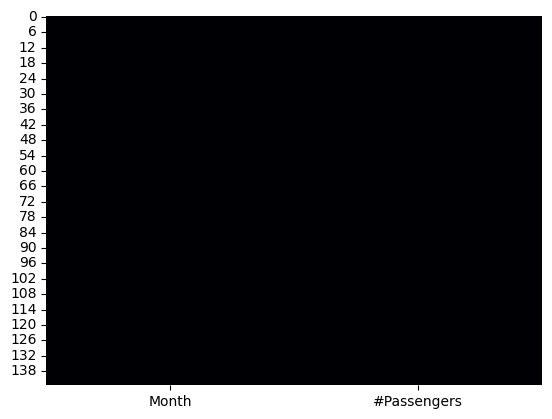

In [6]:
sns.heatmap(data.isnull(),cmap = 'magma',cbar = False);

- **No null values** present in the data!

In [7]:
data.describe()

,#Passengers
count,144.00
mean,280.30
std,119.97
min,104.00
25%,180.00
50%,265.50
75%,360.50
max,622.00


In [8]:
data = pd.read_csv('./AirPassengers.csv')
data['Date'] = pd.to_datetime(data['Month'])
data = data.drop(columns = 'Month')
data = data.set_index('Date')
data = data.rename(columns = {'#Passengers':'Passengers'})
data.head()

,Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


- Converting the datatype of the **Month** column to datetime datatype and setting it as the index of the dataset.
- Renaming the column **Month** to **Date** and **#Passengers** to **Passengers** as well.
- It is a monthly distributed data.

# <center>Time Series Analysis</center>

### Supportive Functions for Time Series Analysis :

In [9]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [10]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

### Components of Time Series :
- A Time Series consists of the following components :

    - **Trend** : Long term direction of the data.
    
    E.g : Year on year rising temperature of the Earth due to Global Warming.
    
    - **Seasonality** : Short term repetitve patterns of the data due to the weather seasons.
    
    E.g : Sale of sweaters specifically in the winter season.
    
    - **Cyclic Variations** : Short term repetitive patterns of the data over a period of 1 year.
    
    E.g : It usually consists of the Business Quarters i.e Q1, Q2, Q3 & Q4.
    
    - **Irregularities** : Random and unforseen fluctuations in the data.
    
    E.g : Occurrences of Earthquakes or Floods, etc.
    
    
- **In order to assess a Time Series, we need to consider the above components and make sure that our data is free from all these components in order to make a forecast.** 

Let's visualize the **Passengers** data for the above components!
- For this purpose, we use a function **seasonal_decompose** from the **statsmodel** library.
- This function has a parameter, **model**, that needs to be assigned the value **additive** or **multiplicative**.
    - **Additive Model** : Data has same width and height of the seasonal patterns or peaks. Trend of the data is linear.
    - **Multiplicative Model** : Data has increasing / decreasing width and height of the seasonal patterns or peaks. Trend of the data is non-linear.

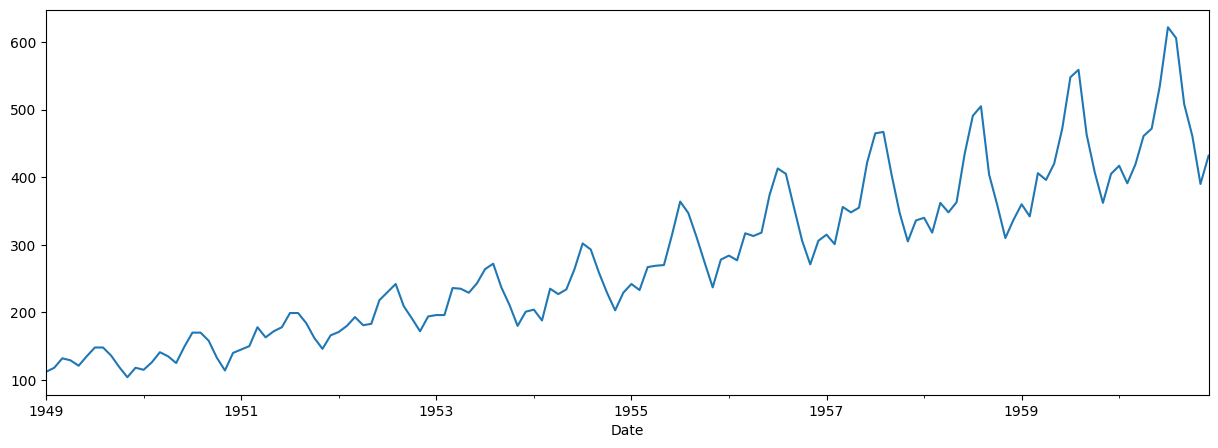

In [11]:
plt.figure(figsize = (15,5))
data['Passengers'].plot();

- From the above graph of **Passengers** data, we can say that it represents a **Multiplicative Model** as the data has increasing width & height of the peaks.
- Let us decompose the multiple components of the **Passengers** time series.

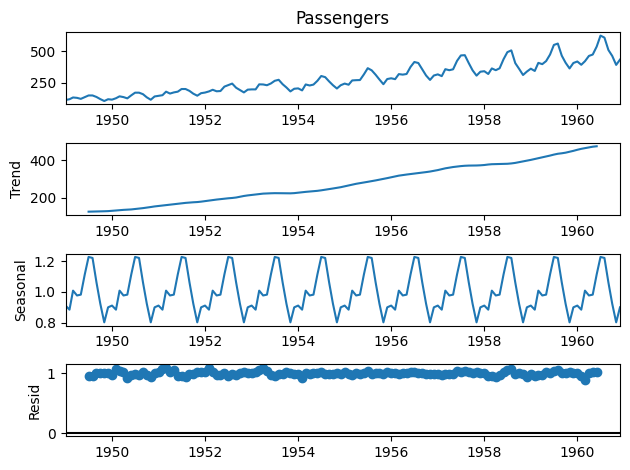

In [12]:
dec = sm.tsa.seasonal_decompose(data['Passengers'],period = 12, model = 'multiplicative').plot()
plt.show()

- Data clearly has a **linear uptrend**.
- A clear cut **seasonal** pattern of a 1 year duration is present in the data.
- We also need to check the statistical parameters w.r.t time. 

### Stationarity :

- **Stationarity** is a concept for time series where statistical parameters like mean, variance, etc are all constant over time.
- For a time series, features are dependent on time i.e **features are a function of time**. Statistical paramters will change values over time as they are extracted from the features.
- If the time series is not stationary, then the predictions deviate from the original values and increase the error as we don't know the changes in these statistical parameters as they are a function of time.
- Thus, by making time series stationary, we kind of nullify the effects of statistical parameters on the forecast.
- To test stationarity, we will use **Augmented Dickey Fuller Test** : 
    - **Null Hypothesis** : It assumes that the time series is non-stationary.
    - **Alternate Hypothesis** : If the null hypothesis is rejected, then the time series is stationary.
    - Output of the **Augmented Dickey Fuller Test** include :
        - **Test Statistic**
        - **p-value**
        - **#Lags Used**
        - **Number of Observations Used**
        - **Critical Value (1%)**
        - **Critical Value (5%)**
        - **Critical Value (10%)**
- For the **Null Hypothesis** to be rejected and accepting that the time series is stationary, there are 2 requirements :
    - **Critical Value (5%)** > **Test Statistic**
    - **p-value** < 0.05

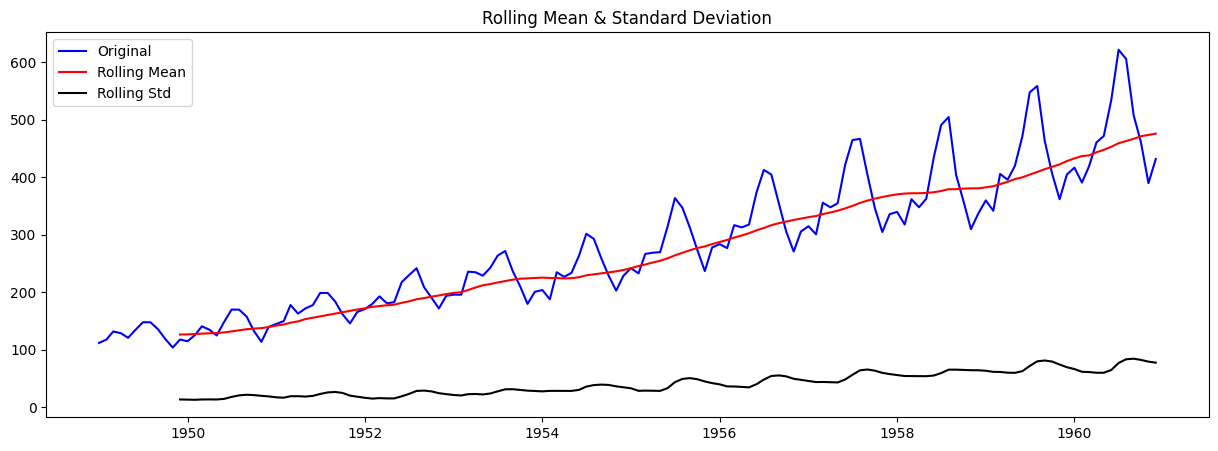

Results of Dickey-Fuller Test:
Test Statistic                  0.82
p-value                         0.99
#Lags Used                     13.00
Number of Observations Used   130.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [13]:
test_stationarity(data['Passengers'])

- For the **Passengers** time series data, 
    - **Rolling Mean** is clearly variable with time. 
    - **Rolling Standard Deviation** is has some crests - troughs that vary according to the time.
    - **Test Statistic : (0.82)** > **Critical Value (5%) : (-2.88)**
    - **p-value (0.99)** > 0.05
- Hence, **Null Hypothesis** cannot be rejected and we can conclude that the above **Passengers** time series is **not stationary**.
- In order to eliminate trend, seasonality and make the time series stationary, we will use **differencing** i.e subtracting the previous value from it's next value. We will work on log values of the data from here!

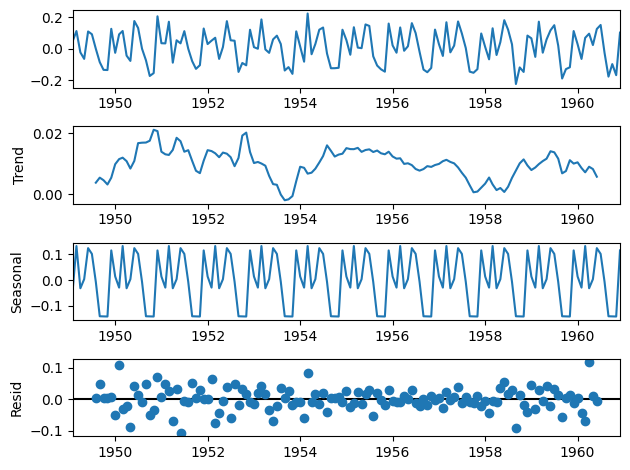

In [90]:
data = pd.read_csv('./AirPassengers.csv')
data['Date'] = pd.to_datetime(data['Month'])
data = data.drop(columns = 'Month')
data = data.set_index('Date')
data = data.rename(columns = {'#Passengers':'Passengers'})
data_diff = data
data_diff['Passengers'] = np.log(data['Passengers'])
data_diff
data_diff = data_diff.diff()
data_diff = data_diff.dropna()
data_diff
dec = sm.tsa.seasonal_decompose(data_diff,period = 12).plot()
plt.show()

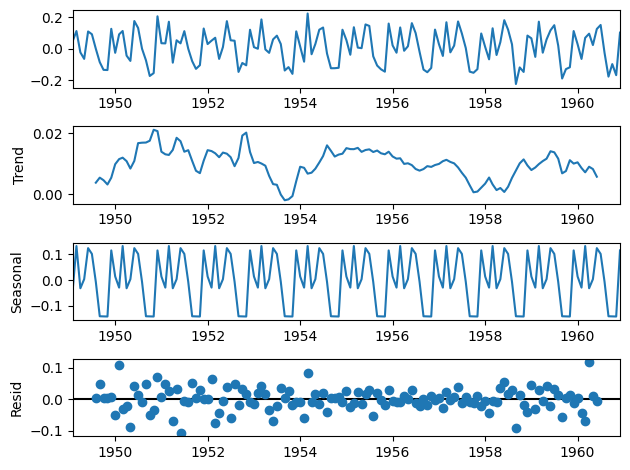

In [90]:
data = pd.read_csv('./AirPassengers.csv')
data['Date'] = pd.to_datetime(data['Month'])
data = data.drop(columns = 'Month')
data = data.set_index('Date')
data = data.rename(columns = {'#Passengers':'Passengers'})
data_diff = data
data_diff['Passengers'] = np.log(data['Passengers'])
data_diff
data_diff = data_diff.diff()
data_diff = data_diff.dropna()
data_diff
dec = sm.tsa.seasonal_decompose(data_diff,period = 12).plot()
plt.show()

- We have taken the **log** of the data to deal with **stationarity** and **differencing** is done to handle **trend** and **seasonality**.
- **Trend** of the data has near about died down & their values have been reduced as well. However, **Seasonality** of the data is clearly visible.
- We now check the **stationarity** of the time series.

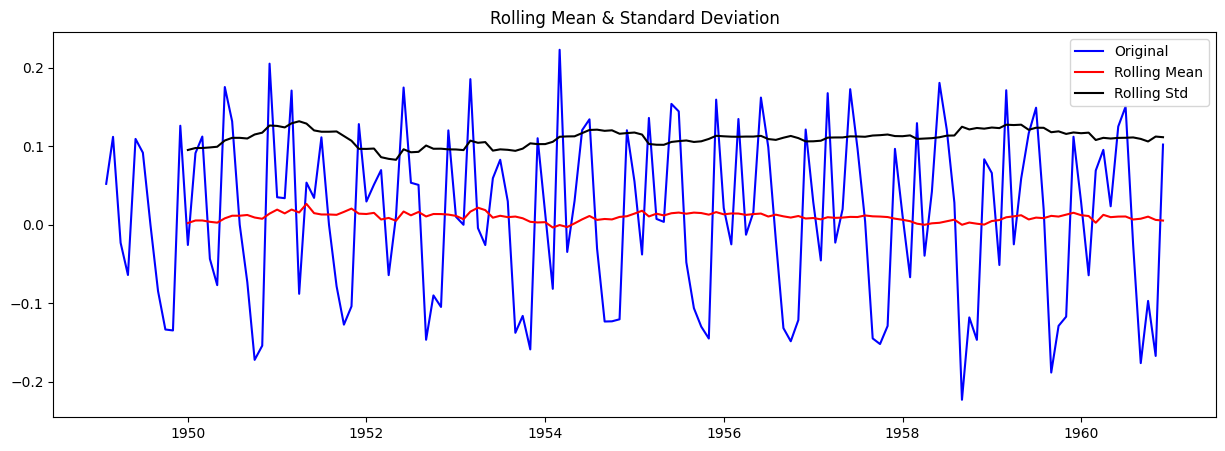

Results of Dickey-Fuller Test:
Test Statistic                 -2.72
p-value                         0.07
#Lags Used                     14.00
Number of Observations Used   128.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [91]:
test_stationarity(data_diff)

- From the outputs of the **Augmented Dickey Fuller Test**,
    - **Rolling Mean** is very close to 0.
    - **Rolling Standard Deviation** displays a slight uptrend over time.
    - **Test Statistic : (-2.83)** > **Critical Value (5%) : (-2.88)**. 
    - **p-value (0.05)** > **0.05**
- From the above values, we will use the above time series despite it just fails on the **stationarity** test.
- Effect of **double-differencing** would be too heavy on the data and might result in poor performance.

# <center>Modeling</center>

## <center>ARIMA</center> 
### <center>Auto Regressive Integrated Moving Average</center> 

- **ARIMA** model is a combination of 3 models :
    - **AR (p) : Auto Regressive**
    - **I (d) : Integrated**
    - **MA (q) : Moving Average**

- **(p,d,q)** is known as the order of the **ARIMA** model. Values of these parameters are based on the above mentioned models.  
    - **p** : Number of auto regressive terms. 
    - **d** : Number of differencing orders required to make the time series stationary.
    - **q** : Number of lagged forecast errors in the prediction equation.

- Selection criteria for the order of **ARIMA** model : 
    - **p** : Lag value where the **Partial Autocorrelation (PACF)** graph cuts off or drops to 0 for the 1st instance.
    - **d** : Number of times differencing is carried out to make the time series stationary.
    - **q** : Lag value where the **Autocorrelation (ACF)** graph crosses the upper confidence interval for the 1st instance.

/usr/local/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


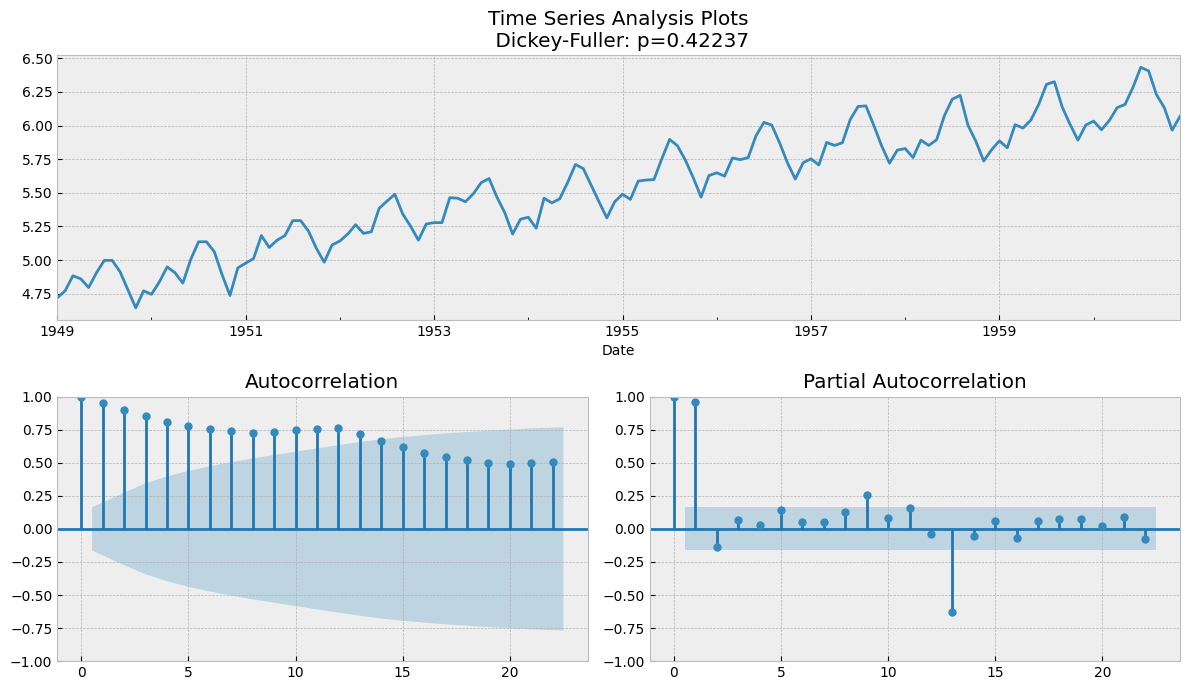

In [62]:
tsplot(data_diff['Passengers'])

- **ACF** graph provides the correlation between the time series & it's lags. For the above time series, we can observe a positive lowering correlation.
- **PACF** graph provides the correlation between the time series and individual lags. These correlation coefficients are unlike the mutual correlations that are calculated in the presence of other features.
- From the **PACF** graph above, the 1st lag is out of the confidence interval and probably the most significant lag. It probably dictates the pattern for the **ACF** graph where the next lag follows it's previous lag.

/usr/local/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


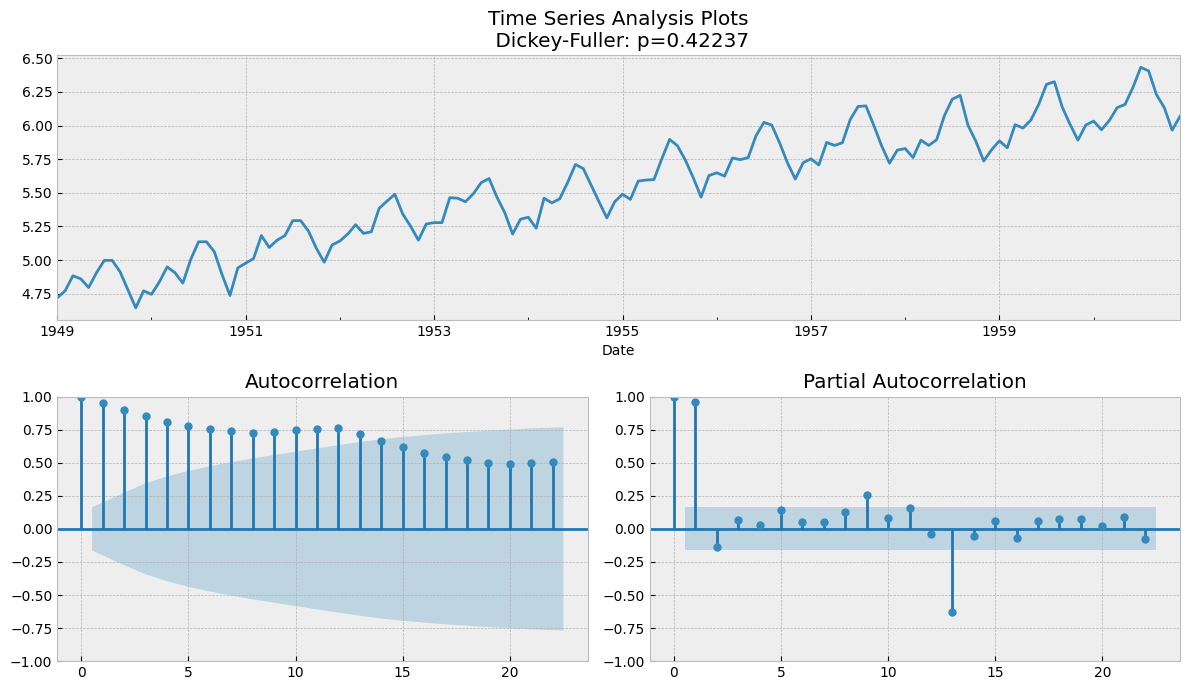

In [63]:
tsplot(data_diff['Passengers'])

- From the above plots, the following order of **ARIMA** model is selected from the selection criteria mentioned above :
    - **p** : 2
    - **d** : 1
    - **q** : 2
- The data passed for model fitting is the **Log_Passengers** data that is non-differenced data and non-stationary data.
- In order to make the series stationary, we difference the time series. Thus, this differencing of data is carried out by the ARIMA model with the help of the **d** parameter that provides info about the order of differencing.
- Thus, the parameters **p** and **q** are selected in such a way that we pass their values assuming the ARIMA model carries out the differencing process and makes the time series stationary.

In [64]:
model = ARIMA(data_diff['Passengers'],order = (2,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 128.890
Date:                Wed, 15 Feb 2023   AIC                           -247.780
Time:                        12:17:51   BIC                           -232.965
Sample:                    01-01-1949   HQIC                          -241.760
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2432      0.166      1.469      0.142      -0.081       0.568
ar.L2          0.2677      0.199      1.344      0.179      -0.123       0.658
ma.L1         -0.0867      0.118     -0.732      0.4

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


### In - Sample Forecasting :

- **In - Sample Forecasting** : Model forecasts values for the existing data points of the time series. It is similar to the train - test format for regression or classification problems. 
- We divide the data into train and test dataset. We reserve the last 30 elements for the test dataset and the remaining for the train dataset.
- For this **In - Sample Forecasting**, we use the **rolling** forecast method i.e we predict or forecast a single value and use this predicted value again for model fitting for predicting the next value.

In [65]:
size = int(len(data) - 30)
train, test = data_diff['Passengers'][0:size], data_diff['Passengers'][size:len(data)]

print('\t ARIMA MODEL : In- Sample Forecasting \n')

history = [x for x in train]
predictions = []

for t in range(len(test)):
    
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit()
    
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    
    obs = test[t]
    history.append(obs)
    
    print('predicted = %f, expected = %f' % (yhat, obs))

	 ARIMA MODEL : In- Sample Forecasting 

predicted = 6.061630, expected = 6.196444
predicted = 6.168391, expected = 6.224558
predicted = 6.173449, expected = 6.001415
predicted = 5.930067, expected = 5.883322
predicted = 5.914086, expected = 5.736572
predicted = 5.716256, expected = 5.820083
predicted = 5.909269, expected = 5.886104
predicted = 5.861406, expected = 5.834811
predicted = 5.855939, expected = 6.006353
predicted = 6.032090, expected = 5.981414
predicted = 5.929349, expected = 6.040255
predicted = 6.069368, expected = 6.156979
predicted = 6.115608, expected = 6.306275
predicted = 6.304533, expected = 6.326149
predicted = 6.246167, expected = 6.137727
predicted = 6.096057, expected = 6.008813
predicted = 6.002705, expected = 5.891644
predicted = 5.893931, expected = 6.003887
predicted = 6.062997, expected = 6.033086
predicted = 5.998166, expected = 5.968708
predicted = 5.987892, expected = 6.037871
predicted = 6.049422, expected = 6.133398
predicted = 6.133436, expected = 6.

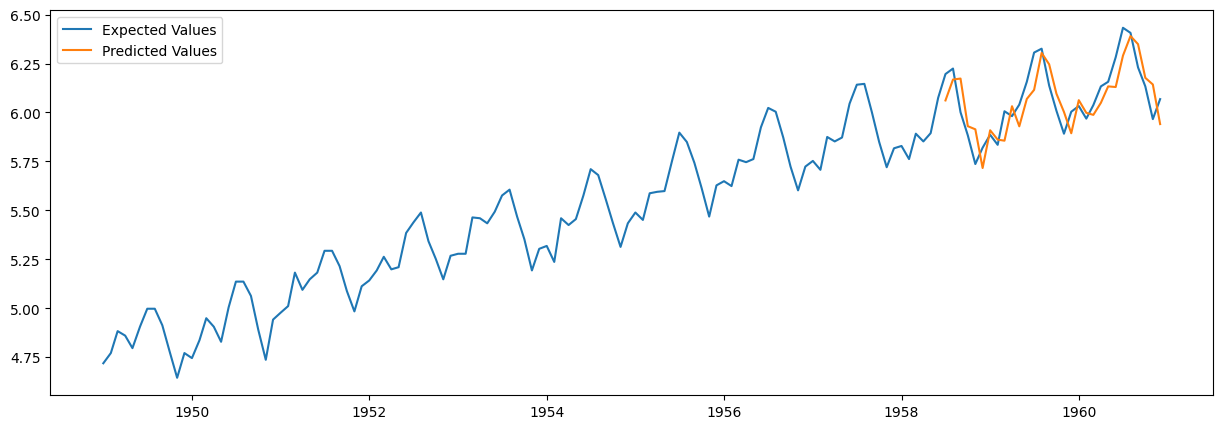

In [67]:
predictions_series = pd.Series(predictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(data_diff['Passengers'],label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()

- **Predicted Values** and **Expected Values** are very close.

In [68]:
error = np.sqrt(mean_squared_error(test,predictions))
print('Test RMSE: %.4f' % error)

Test RMSE: 0.1067


- Test RMSE value is quite high.
- Presence of seasonality as well as order of the **ARIMA** model might have had an effect on the model performance. We will move on to **Out - Of - Sample Forecasting**.

### Out - of - Sample Forecasting :

- **Out - of - Sample Forecasting** : Model forecasts values for the future data points by imputing the datetime index values of the time series.
- We create a new dataframe with the future index values and same columns as the dataframe that we use for model fitting. 
- For this **Out - of - Sample Forecasting**, we use the **rolling** method by using **forecast function** and **predict function**.
- In the **rolling** method, we forecast or predict the next single value, use this predicted value again for model fitting that is then used for predicting the next value.

In [73]:
from pandas.tseries.offsets import DateOffset
future_dates = [data_diff.index[-1] + DateOffset(weeks = x) for x in range(0,49)]

# New dataframe for storing the future values
df1 = pd.DataFrame(index = future_dates[1:],columns = data_diff.columns)

forecast = pd.concat([data_diff,df1])
forecast['ARIMA_Forecast_Function'] = np.NaN
forecast['ARIMA_Predict_Function'] = np.NaN
forecast.head(),forecast.tail()

(            Passengers  ARIMA_Forecast_Function  ARIMA_Predict_Function
 1949-01-01        4.72                      NaN                     NaN
 1949-02-01        4.77                      NaN                     NaN
 1949-03-01        4.88                      NaN                     NaN
 1949-04-01        4.86                      NaN                     NaN
 1949-05-01        4.80                      NaN                     NaN,
             Passengers  ARIMA_Forecast_Function  ARIMA_Predict_Function
 1961-10-05         NaN                      NaN                     NaN
 1961-10-12         NaN                      NaN                     NaN
 1961-10-19         NaN                      NaN                     NaN
 1961-10-26         NaN                      NaN                     NaN
 1961-11-02         NaN                      NaN                     NaN)

- We create 2 new columns for storing the values forecasted or predicted into **ARIMA_Forecast_Function** and **ARIMA_Predict_Function**.

#### Forecast Function : 

In [75]:
ARIMA_history_f = [x for x in train]
f1 = []

for t in range(len(df1)):
    
    model = ARIMA(ARIMA_history_f, order = (2,1,2))
    model_fit = model.fit()
    
    output = model_fit.forecast()[0]
    
    ARIMA_history_f.append(output)
    f1.append(output)
    
for i in range(len(f1)):
    forecast.iloc[144 + i,1] = f1[i]
forecast.tail()

,Passengers,ARIMA_Forecast_Function,ARIMA_Predict_Function
1961-10-05,NaN,5.96,5.96
1961-10-12,NaN,5.96,5.96
1961-10-19,NaN,5.96,5.96
1961-10-26,NaN,5.96,5.96
1961-11-02,NaN,5.96,5.96


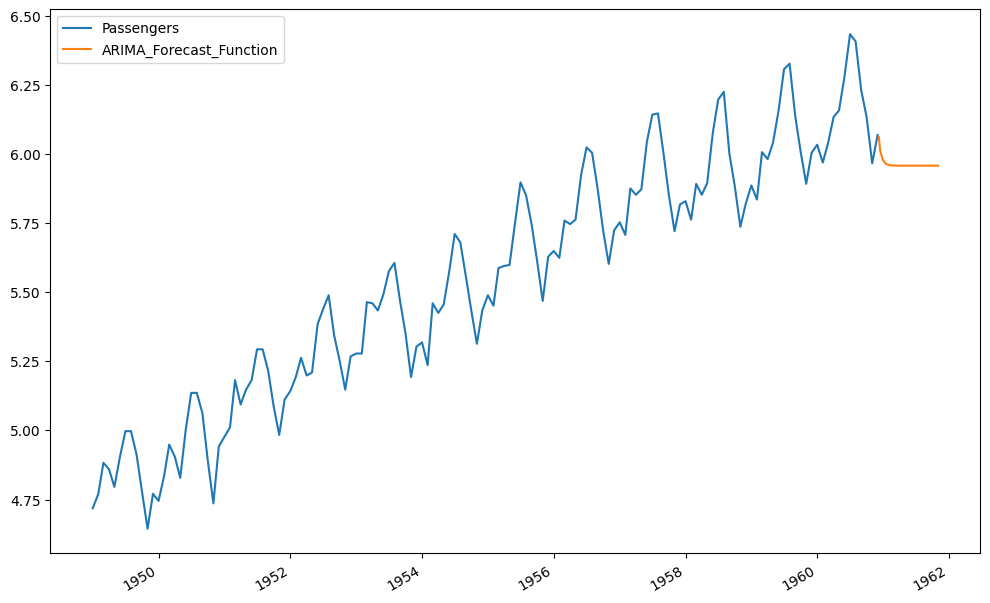

In [71]:
forecast[['Passengers','ARIMA_Forecast_Function']].plot(figsize = (12,8));

- Values generated by the **forecast_function** are rising. The model clearly did not understand the seasonal patterns of the data.

#### Predict Function :

In [74]:
ARIMA_history_p = [x for x in train]
f2 = []

for t in range(len(df1)):
    
    model = ARIMA(ARIMA_history_p, order = (2,1,2))
    model_fit = model.fit()
    
    output = model_fit.predict(start = len(ARIMA_history_p),
                               end = len(ARIMA_history_p),
                               typ = 'levels')[0]
    
    ARIMA_history_p.append(output)
    f2.append(output)
    
for i in range(len(f2)):
    forecast.iloc[144 + i,2] = f2[i]
forecast.tail()

,Passengers,ARIMA_Forecast_Function,ARIMA_Predict_Function
1961-10-05,NaN,NaN,5.96
1961-10-12,NaN,NaN,5.96
1961-10-19,NaN,NaN,5.96
1961-10-26,NaN,NaN,5.96
1961-11-02,NaN,NaN,5.96


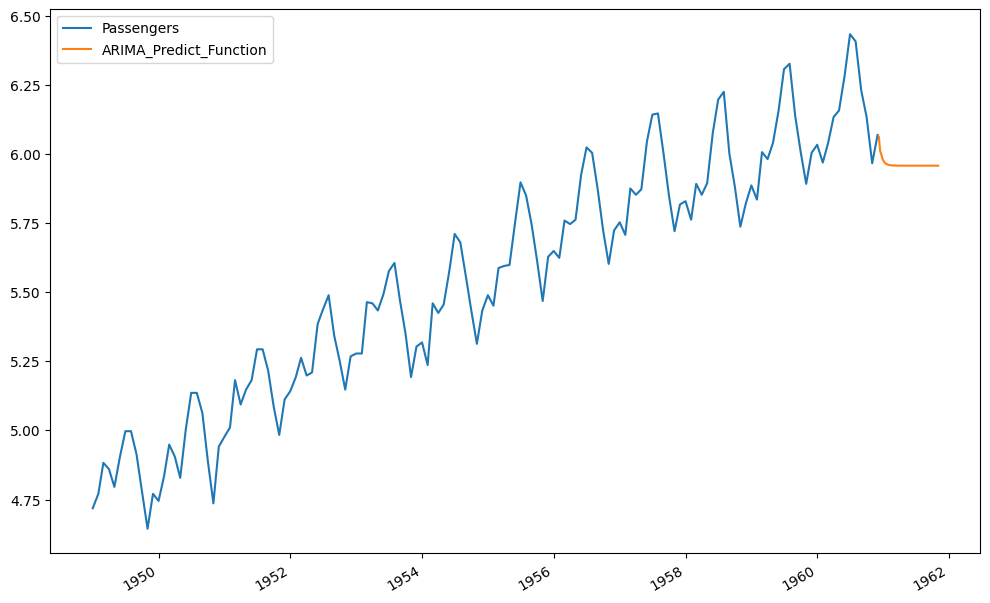

In [76]:
forecast[['Passengers','ARIMA_Predict_Function']].plot(figsize = (12,8));

- Similar pattern can be observed for the values generated by the **predict_function**. 
- Let's compare the values generated by the **forecast_function** and **predict_function**.

In [77]:
sum(f1) == sum(f2)

True

- For the above trained **ARIMA** model, values generated by **forecast_function** and **predict function** are either exactly identical or just differ by a few decimal points!
- The model clearly did not capture the **seasonal patterns** of the data.

## <center>SARIMA</center>
### <center>Seasonal Auto Regressive Integrated Moving Average</center> 

- **SARIMA** model is an extension of the ARIMA model that can handle the seasonal effects of the data.
- It has kind of 2 orders **(p,d,q) x (P,D,Q,M)**. 
- **(p,d,q)** is the order that is similar to the order of the **ARIMA** model. 
- **(P,D,Q,M)** is known as the Seasonal Order where **(P,D,Q)** are similar to the **(p,d,q)** of the ARIMA model. 
- It's selection criteria is similar as well with an important condition i.e to handle the seasonality by differencing the data with the frequency of seasonal period or periodicity, **M** and check the **PACF** & **ACF** values at the **Mth** lag value. 

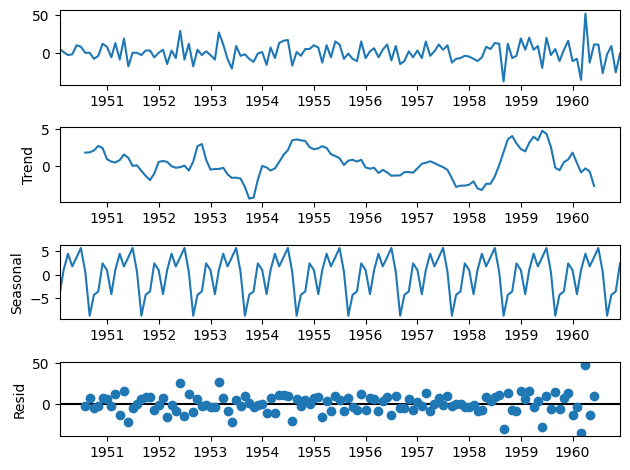

In [33]:
data_diff_seas = data_diff.diff(12)
data_diff_seas = data_diff_seas.dropna()
dec = sm.tsa.seasonal_decompose(data_diff_seas,period = 12)
dec.plot()
plt.show()

- Our data is in **monthly format** and the **seasonal period is of 1 year**.
- Hence, we difference the already differenced data by a periodicity, **M**, value of 12.
- The seasonality of the data has not completely died down but it's values have been dropped.
- We will check this seasonal differenced data for stationarity.

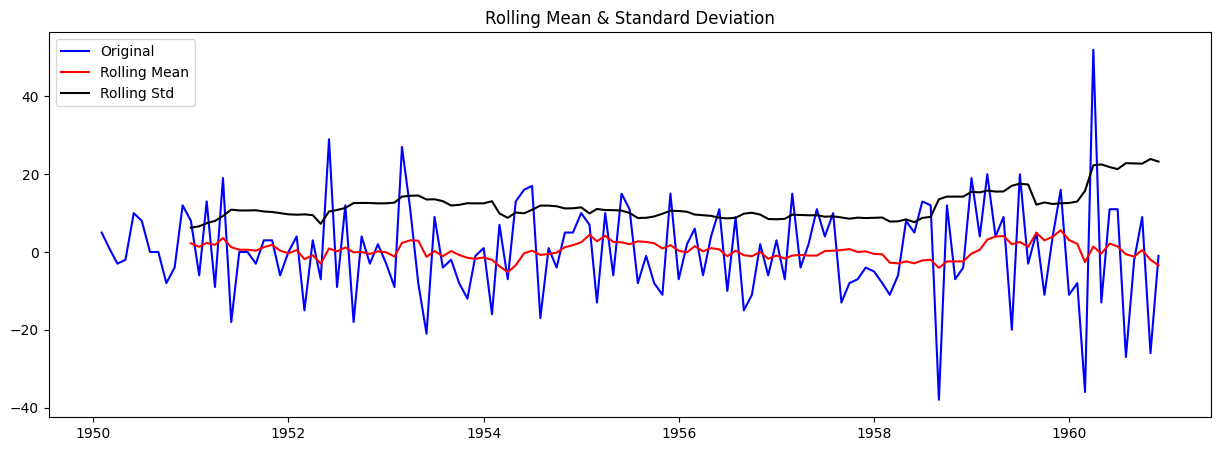

Results of Dickey-Fuller Test:
Test Statistic                -15.60
p-value                         0.00
#Lags Used                      0.00
Number of Observations Used   130.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [34]:
test_stationarity(data_diff_seas['Passengers'])

- From the outputs of the **Augmented Dickey Fuller Test**,
    - **Rolling Mean** is very close to 0.
    - **Rolling Standard Deviation** is near about constant with certain crests - troughs present throughout.
    - **Critical Value (5%) : (-2.88)** > **Test Statistic : (-15.60)**. We can say that the time series is **stationary with 99%** confidence as the **Test Statistic** is less than **Critical Value (1%)** as well.
    - **0.05** > **p-value (0.00)**
- From these outputs, we can reject the **Null Hypothesis** and accept the **Alternate Hypothesis** i.e we can say that the above **time series is stationary**.

/usr/local/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


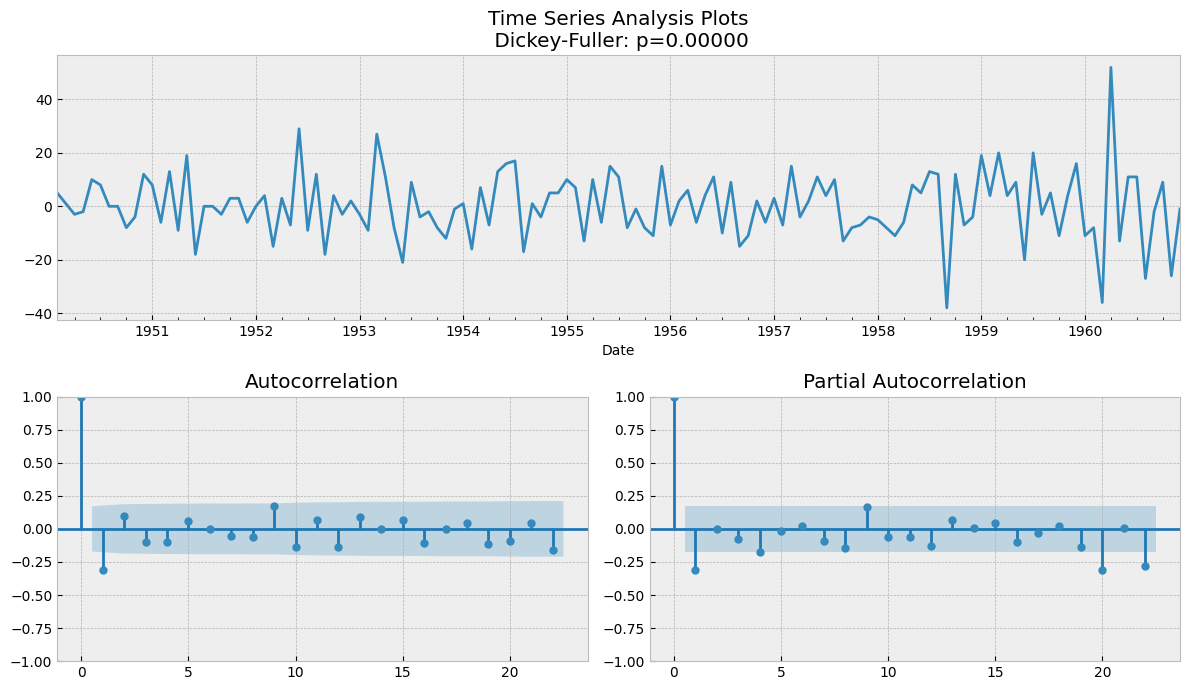

In [35]:
tsplot(data_diff_seas['Passengers'])

- For the **SARIMA** model, order of **(p,d,q)** will be same as the order of the **ARIMA** model above. 
- For **(P,D,Q,M)** :
    - **P** : 0
    - **D** : 1
    - **Q** : 1
    - **M** : 12

In [ ]:
model = sm.tsa.statespace.SARIMAX(data['Passengers'],order = (2,1,2),seasonal_order = (0,1,1,12))
model_fit = model.fit()
print(model_fit.summary())

### In - Sample Forecasting :

- **In - Sample Forecasting** : Model forecasts values for the existing data points of the time series. It is similar to the train - test format for regression or classification problems. 
- We divide the data into train and test dataset. We reserve the last 30 elements for the test dataset and the remaining for the train dataset similar to the approach of **ARIMA** model.
- For this **In - Sample Forecasting**, we use the **rolling** forecast method i.e we predict or forecast a single value and use this predicted value again for model fitting for predicting the next value.

In [ ]:
size = int(len(data) - 30)
train, test = data['Passengers'][0:size], data['Passengers'][size:len(data)]

print('\t SARIMA MODEL : In - Sample Forecasting \n')

history = [x for x in train]
predictions = []

for t in range(len(test)):
    
    model = sm.tsa.statespace.SARIMAX(history,order = (2,1,2),seasonal_order = (0,1,1,12))
    model_fit = model.fit()
    
    output = model_fit.forecast()
    
    yhat = output[0]
    predictions.append(float(yhat))
    
    obs = test[t]
    history.append(obs)
    
    print('predicted = %f, expected = %f' % (yhat, obs))

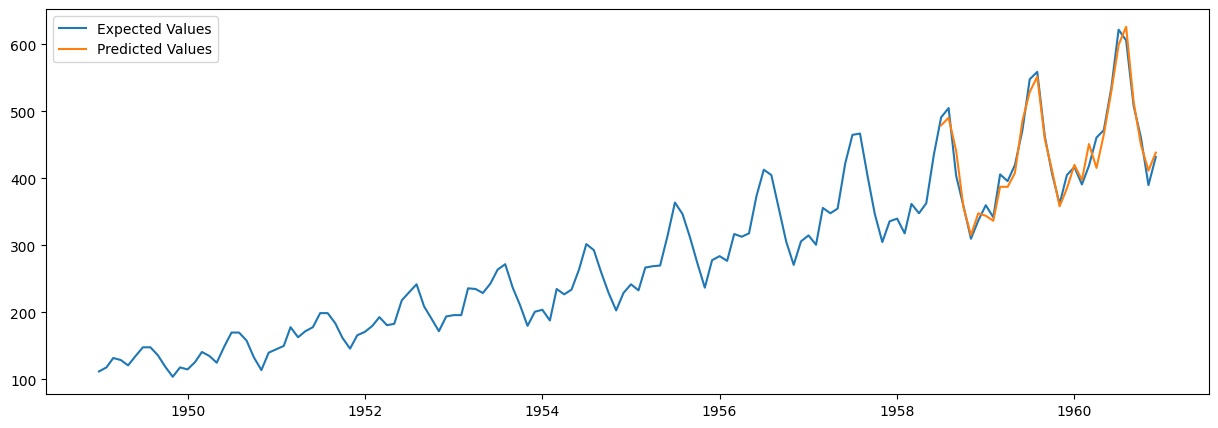

In [38]:
predictions_series = pd.Series(predictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(data['Passengers'],label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()

- The above trained **SARIMA model** has performed quite well in forecasting in - sample values

In [39]:
error = np.sqrt(mean_squared_error(test,predictions))
print('Test RMSE: %.4f' % error)

Test RMSE: 16.9252


- Test RMSE value is ok!

### Out - of - Sample Forecasting :

- **Out - of - Sample Forecasting** : Model forecasts values for the future data points by imputing the datetime index values of the time series.
- We create a new dataframe with the future index values and same columns as the dataframe that we use for model fitting. 
- For this **Out - of - Sample Forecasting**, we use the **non-rolling** method by using **forecast function** and **predict function**.
- In the **non-rolling** method, we forecast or predict all future values at once. We store these future values into 2 new columns **SARIMA_Forecast_Function** and **SARIMA_Predict_Function** in the existing forecast dataframe.

In [40]:
forecast['SARIMA_Forecast_Function'] = np.NaN
forecast['SARIMA_Predict_Function'] = np.NaN
forecast.head()

,Passengers,ARIMA_Forecast_Function,ARIMA_Predict_Function,SARIMA_Forecast_Function,SARIMA_Predict_Function
1949-01-01,112,NaN,NaN,NaN,NaN
1949-02-01,118,NaN,NaN,NaN,NaN
1949-03-01,132,NaN,NaN,NaN,NaN
1949-04-01,129,NaN,NaN,NaN,NaN
1949-05-01,121,NaN,NaN,NaN,NaN


#### Forecast Function :

In [ ]:
SARIMA_history_f = [x for x in train]
f3 = []

for t in (range(len(df1))):
    
    model = sm.tsa.statespace.SARIMAX(SARIMA_history_f,order = (2,1,2),seasonal_order = (0,1,1,12))
    model_fit = model.fit()
    
    output = model_fit.forecast()[0]
    
    SARIMA_history_f.append(output)
    f3.append(output)
    
for i in range(len(f3)):
    forecast.iloc[144 + i,3] = f3[i]
forecast.tail()

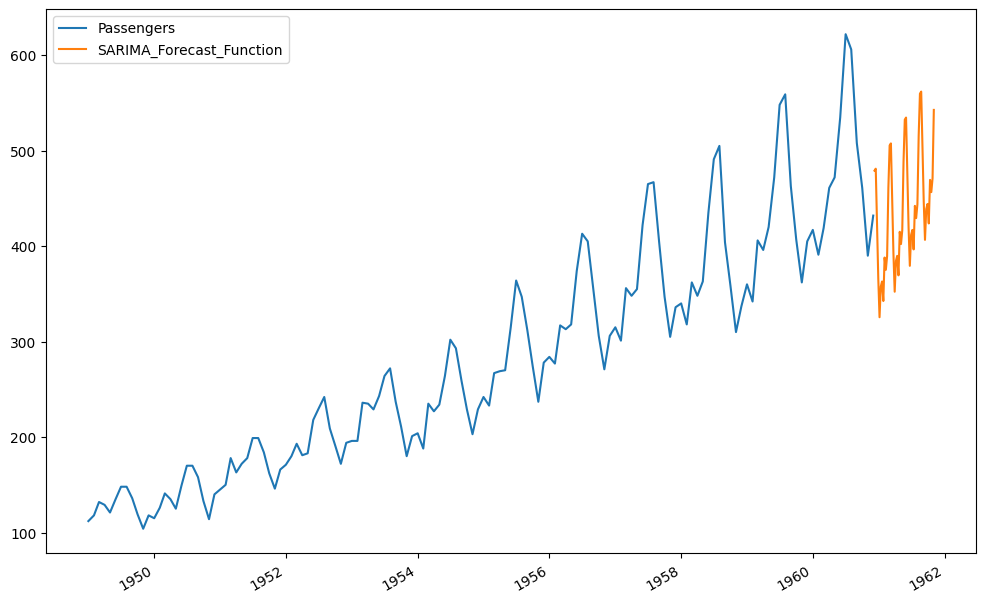

In [42]:
forecast[['Passengers','SARIMA_Forecast_Function']].plot(figsize = (12,8));

- From the above graph, we can say that **SARIMA** model understood the trend, seasonal pattern but it did not understand the increasing width of the seasonal pattern that is a characteristic feature of a **multiplicative** model.

#### Predict Function :

In [ ]:
SARIMA_history_p = [x for x in train]
f4 = []

for t in range(len(df1)):
    
    model = sm.tsa.statespace.SARIMAX(SARIMA_history_p,order = (2,1,2),seasonal_order = (0,1,1,12))
    model_fit = model.fit()
    
    output = model_fit.predict(start = len(SARIMA_history_p),end = len(SARIMA_history_p),typ = 'levels')[0]
    
    SARIMA_history_p.append(output)
    f4.append(output)
    
for i in range(len(f4)):
    forecast.iloc[144 + i,4] = f4[i]
forecast.tail()

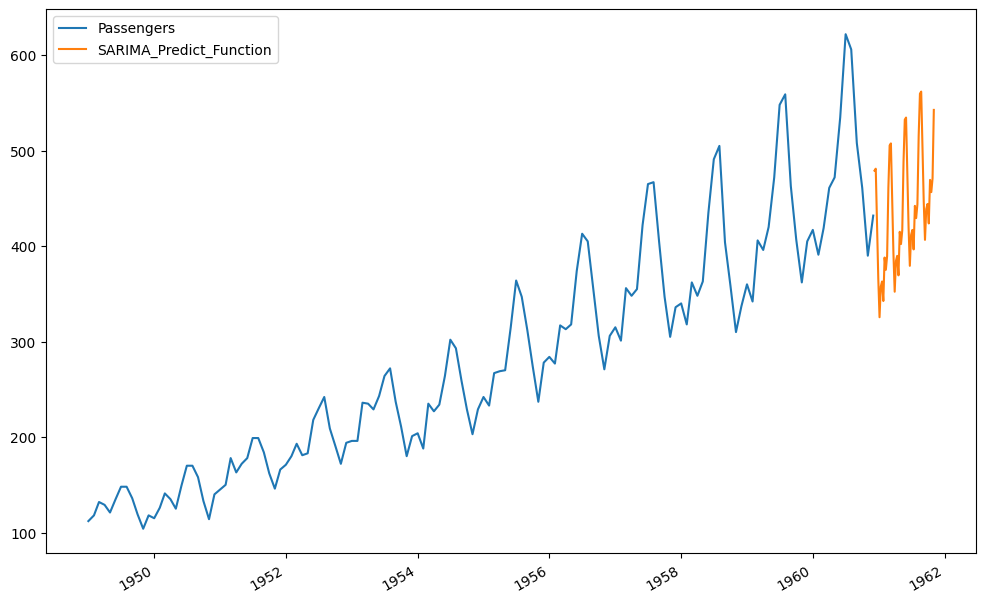

In [44]:
forecast[['Passengers','SARIMA_Predict_Function']].plot(figsize = (12,8));

- **SARIMA_Predict_Function** graph displays a similar pattern as the **SARIMA_Forecast_Function**.

In [45]:
sum(f3) == sum(f4)

True

- Values of **SARIMA_Predict_Function** and **SARIMA_Forecast_Function** are identical or slightly different.

# <center>Conclusion</center>

- This is a another good dataset for understanding **Time Series Analysis** problems using weekly data. 


- For this **Time Series Analysis**, data did not undergo the log transformation on purpose. It was just to check the effects of it. Use of square root is another option for the log transformation.


- Order selection of **ARIMA** and **SARIMA**, stationarity, looking into different visualizations, etc can be a challenging task.


- **ARIMA** and **SARIMA** model forecasting future values using **forecast_function** & **predict_function** for **Out - of - Sample Forecasting** using **rolling** method takes up more time than future values predicted using **non-rolling** method in the [Avocado Price Forecasting](https://www.kaggle.com/code/tanmay111999/avocado-price-forecast-arima-sarima) notebook.

## Other Work :

#### [Off topic Notebooks](https://www.kaggle.com/tanmay111999/code)
- Recently, 3 new notebooks on the topic **Binary Classification** can be found :
    - [Heart Disease Prediction](https://www.kaggle.com/code/tanmay111999/approach-for-binary-classification-heart-failure)
    - [Heart Failure Prediction](https://www.kaggle.com/code/tanmay111999/beginner-friendly-extensive-eda-modeling)
    - [Credit Card Fraud Detection : Imbalanced Dataset](https://www.kaggle.com/code/tanmay111999/smote-for-imbalanced-data-beginner-friendly)
- Other Notebooks include work on [Image Classification using pretrained models](https://www.kaggle.com/code/tanmay111999/basic-image-classification-vgg16-ml-algorithms).